# Load Package

In [1]:
import os
from collections import defaultdict
import pandas as pd
import re
import locale
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from googletrans import Translator
import jieba
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
import seaborn as sns

/Users/muxuan/anaconda3/envs/my474/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/muxuan/anaconda3/envs/my474/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/muxuan/anaconda3/envs/my474/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/muxuan/anaconda3/envs/my474/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please u

# Load Dataset

In [ ]:
# Path to the directory containing the CSV files
celebrity_path = ''
activity_path = ''
repost_path = ''

celebrity = pd.read_csv(celebrity_path, encoding='utf-8')
activity = pd.read_csv(activity_path, encoding='utf-8')
repost = pd.read_csv(repost_path, encoding='utf-8')

# Figure 1

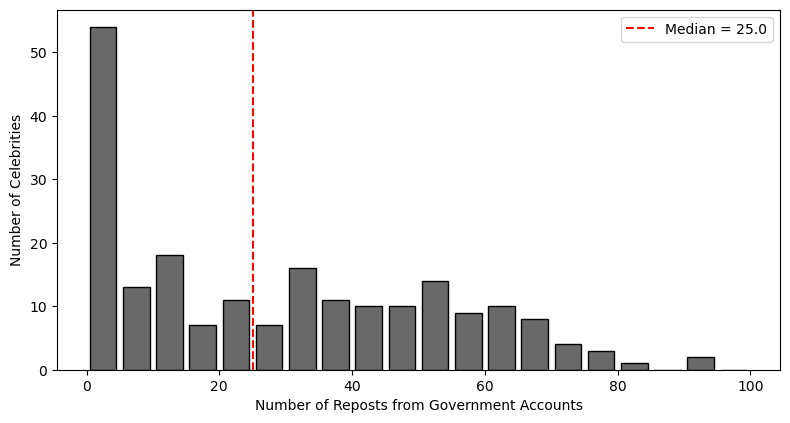

In [3]:
# Count reposts per user_id
repost_counts = repost['user_id'].value_counts().rename_axis('user_id').reset_index(name='repost_count')

# Merge with users dataframe
user_repost_counts = pd.merge(celebrity, repost_counts, on='user_id', how='left').fillna(0)
user_repost_counts['repost_count'] = user_repost_counts['repost_count'].astype(int)

# Define bins
max_count = user_repost_counts['repost_count'].max()
bin_edges = list(range(0, max_count + 11, 5))

# Median value
median_val = user_repost_counts['repost_count'].median()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(user_repost_counts['repost_count'], bins=bin_edges, rwidth=0.8,
        color='dimgray', edgecolor='black')

# Labels and title
ax.set_xlabel(r'Number of Reposts from Government Accounts', fontsize=10)
ax.set_ylabel(r'Number of Celebrities', fontsize=10)

# Median line
ax.axvline(median_val, color='red', linestyle='--', linewidth=1.5,
            label=fr'Median = {median_val:.1f}')
ax.legend()


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


# Figure 2

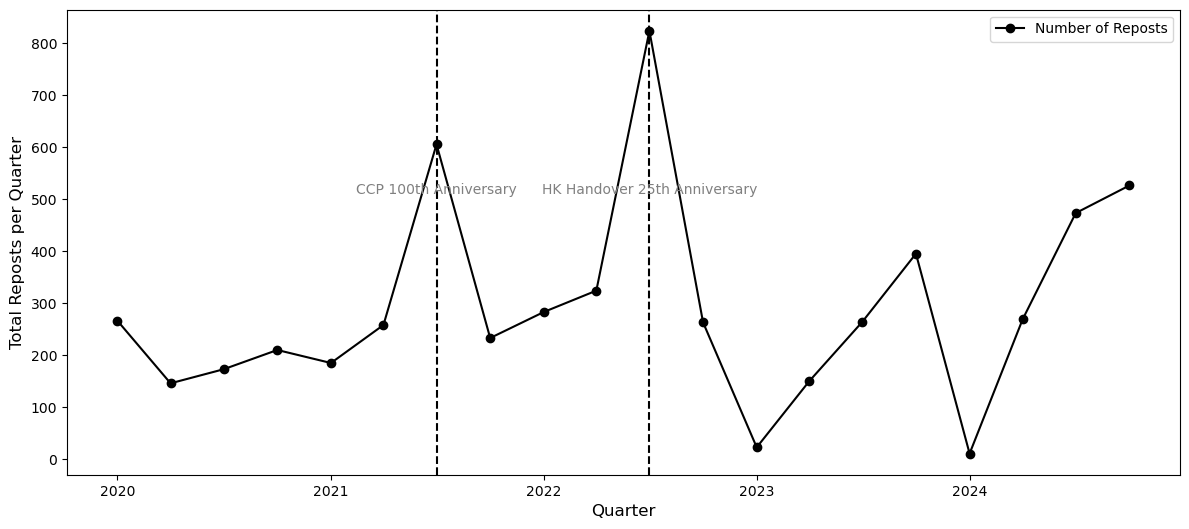

In [4]:
# Convert post_time to quarterly periods
repost['quarter'] = pd.to_datetime(repost['post_time']).dt.to_period('Q').dt.to_timestamp()
quarterly_df = repost.groupby('quarter').size().reset_index(name='repost_count')

# Important political events
events = {
    '2021-07-01': "CCP 100th Anniversary",
    '2022-07-01': "HK Handover 25th Anniversary"
}


# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(quarterly_df['quarter'], quarterly_df['repost_count'], marker='o', color='black', label='Number of Reposts')

# Add vertical lines and horizontal annotations at a fixed height 
y_pos = ax.get_ylim()[1] * 0.6  

for date_str, label in events.items():
    date = pd.to_datetime(date_str)
    ax.axvline(x=date, color='black', linestyle='--')
    ax.text(date, y_pos, label, ha='center', va='center', color='gray', fontsize=10)

# Labels and title
# Clearer labels
ax.set_xlabel(r'Quarter', fontsize=12)
ax.set_ylabel(r'Total Reposts per Quarter', fontsize=12)

ax.legend()
ax.grid(False)


# Layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# Figure 3

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/z6/_3yl52jx6mv32qmlrky888vh0000gn/T/jieba.cache
Loading model cost 0.415 seconds.
Prefix dict has been built successfully.


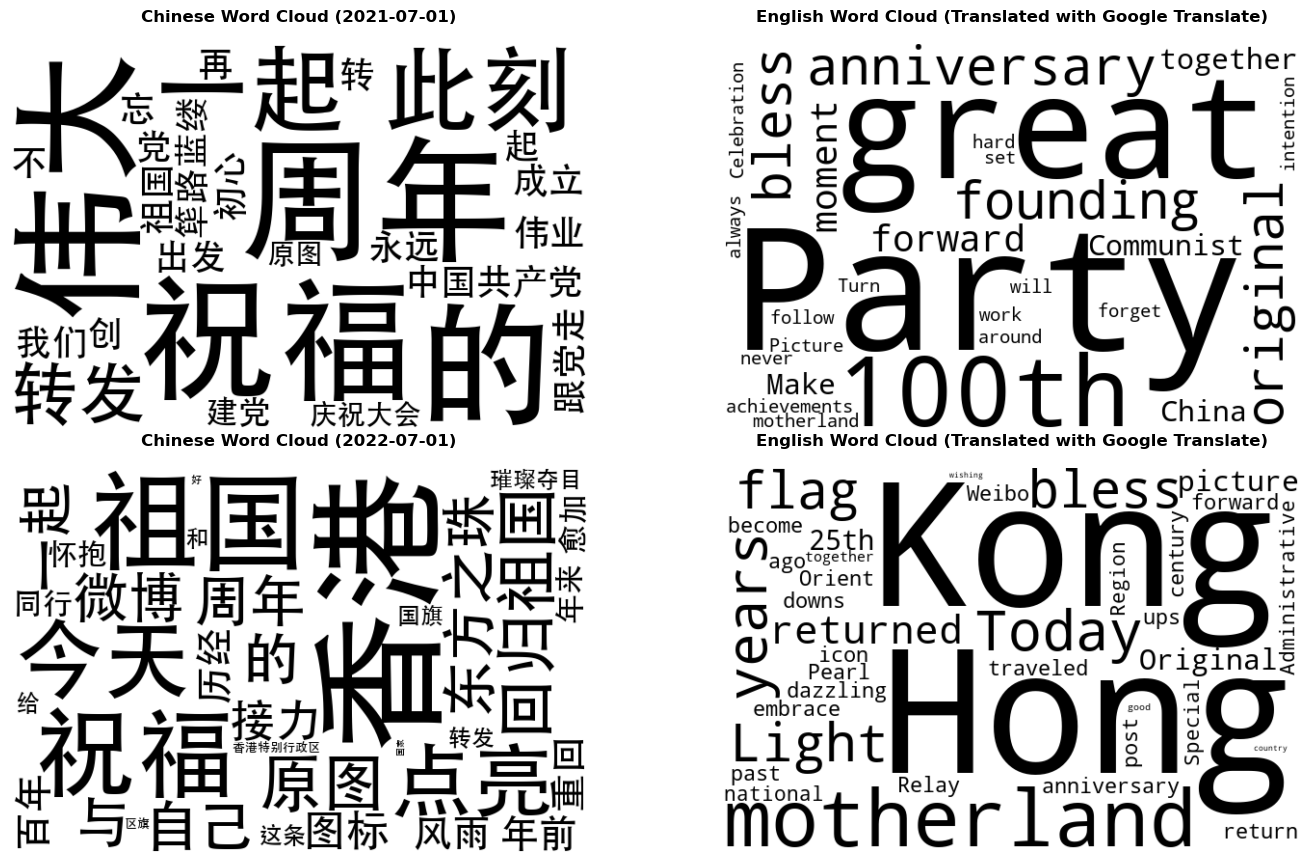

In [ ]:
# Make a copy of repost DataFrame
repost_copy = repost.copy()

# Prepare data
repost_copy['post_time'] = pd.to_datetime(repost_copy['post_time'], errors='coerce')
repost_copy['date'] = repost_copy['post_time'].dt.date

# Target dates
target_dates = ['2021-07-01', '2022-07-01']
translator = Translator()

# Create a 2x2 subplot with clean style
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Process each date
for i, target_date in enumerate(target_dates):
    # Filter and segment
    filtered = repost_copy[repost_copy['date'] == pd.to_datetime(target_date).date()]
    all_text = ' '.join(filtered['message'].dropna().astype(str))
    segmented = ' '.join(jieba.cut(all_text))

    # Translate
    try:
        translated = translator.translate(segmented[:4500], src='zh-CN', dest='en').text
    except Exception as e:
        print(f"Translation failed for {target_date}: {e}")
        translated = segmented

    # Chinese Word Cloud - clean black and white style
    wordcloud_cn = WordCloud(
        font_path='/System/Library/Fonts/STHeiti Medium.ttc',
        background_color='white',
        width=600,
        height=400,
        max_words=80,
        relative_scaling=0.6,
        min_font_size=8,
        color_func=lambda *args, **kwargs: "black",  # All black text
        collocations=False,
        prefer_horizontal=0.9
    ).generate(segmented)

    # English Word Cloud - clean black and white style
    wordcloud_en = WordCloud(
        background_color='white',
        width=600,
        height=400,
        max_words=80,
        relative_scaling=0.6,
        min_font_size=8,
        color_func=lambda *args, **kwargs: "black",  # All black text
        collocations=False,
        prefer_horizontal=0.9
    ).generate(translated)

    # Plot with titles above each word cloud
    axs[i, 0].text(0.5, 1.05, f'Chinese Word Cloud ({target_date})', 
                   transform=axs[i, 0].transAxes, ha='center', va='bottom', 
                   fontsize=12, fontweight='bold')
    axs[i, 0].imshow(wordcloud_cn, interpolation='bilinear')
    axs[i, 0].axis('off')

    axs[i, 1].text(0.5, 1.05, f'English Word Cloud (Translated with Google Translate)', 
                   transform=axs[i, 1].transAxes, ha='center', va='bottom', 
                   fontsize=12, fontweight='bold')
    axs[i, 1].imshow(wordcloud_en, interpolation='bilinear')
    axs[i, 1].axis('off')


# Minimal spacing
plt.tight_layout(rect=[0, 0.06, 1, 0.92])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


# Figure 4 and Figure 10

In [ ]:
# Make a copy of repost DataFrame for further analysis
repost_df = repost.copy()

# Step 1: Segment both columns with Jieba
def segment(text):
    return ' '.join(jieba.lcut(str(text)))  # handle NaN gracefully

repost_df['repost_seg'] = repost_df['repost_message'].apply(segment)
repost_df['message_seg'] = repost_df['message'].apply(segment)

# Step 2: Row-wise cosine similarity
similarities = []

vectorizer = TfidfVectorizer()

for idx, row in repost_df.iterrows():
    pair_texts = [row['repost_seg'], row['message_seg']]
    tfidf = vectorizer.fit_transform(pair_texts)
    sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
    similarities.append(sim)

# Step 3: Store similarity score in the DataFrame
repost_df['c2g_similarity_tf'] = similarities


In [ ]:
#  Load multilingual model that works well with Chinese
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Convert texts to strings
repost_texts = repost_df['repost_message'].astype(str).tolist()
gov_texts = repost_df['message'].astype(str).tolist()

# Encode texts
repost_embeddings = model.encode(repost_texts, convert_to_tensor=True)
gov_embeddings = model.encode(gov_texts, convert_to_tensor=True)

# Compute row-wise cosine similarity (diagonal of the similarity matrix)
cos_sims = cosine_similarity(repost_embeddings.cpu(), gov_embeddings.cpu()).diagonal()

# Assign to DataFrame
repost_df['c2g_similarity_bert'] = cos_sims

Found similarity columns: ['c2g_similarity_tf', 'c2g_similarity_bert']
This is for figure 10


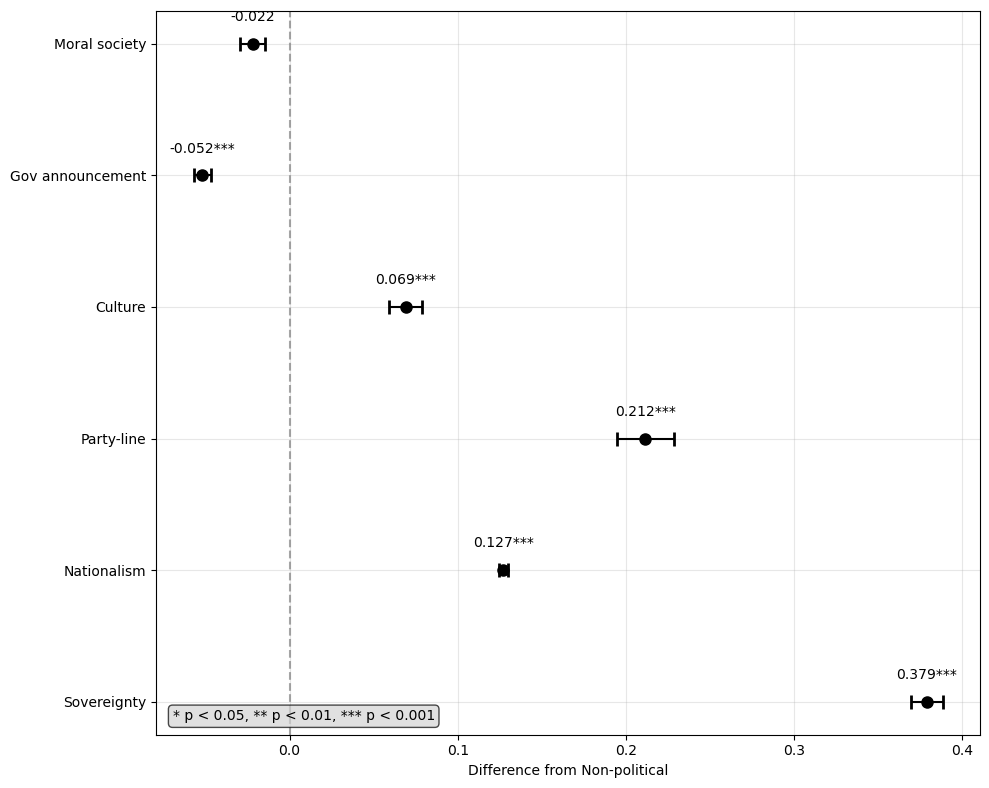

This is for figure 4


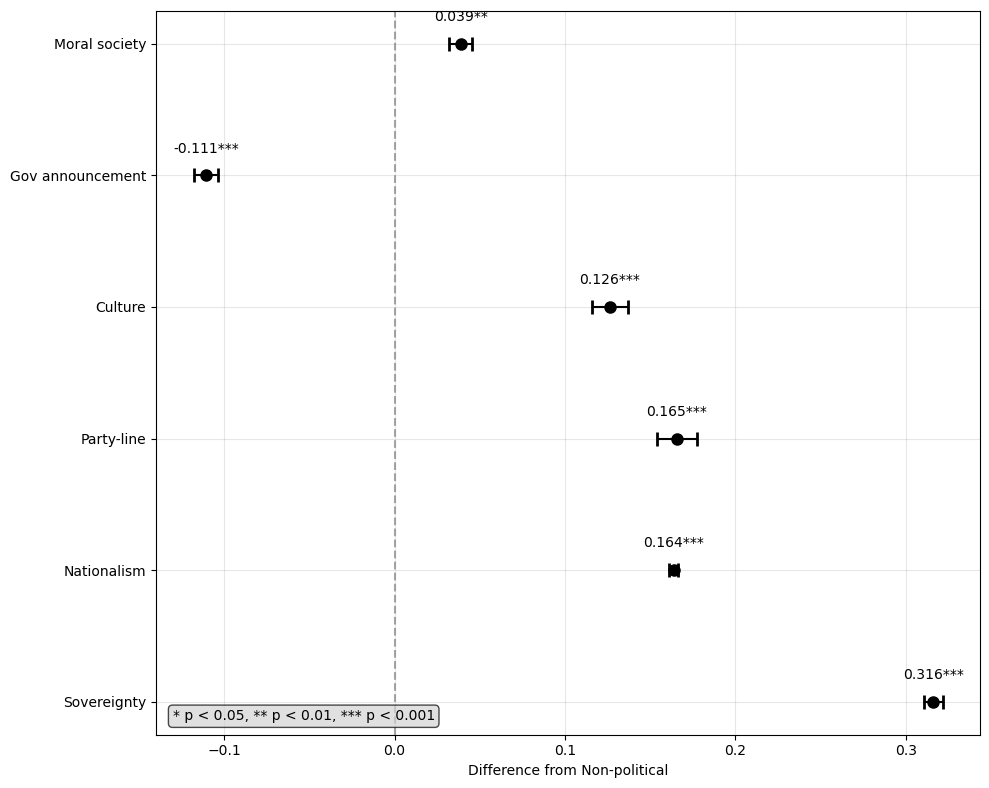

In [ ]:
political_mapping = {
    0: "Non-political",
    1: "Sovereignty", 
    2: "Nationalism",
    3: "Party-line",
    4: "Culture",
    5: "Gov announcement",
    6: "Moral society"
}

def compute_similarity_differences(df, similarity_columns):
    """
    Compute differences from non-political baseline for each similarity measure
    """
    results = {}
    
    for col in similarity_columns:
        # Get baseline (non-political) mean
        baseline = df[df['type'] == 0][col].mean()
        
        # Compute differences for each type
        type_differences = {}
        type_stats = {}
        
        for political_type in range(1, 7):  # Types 1-6 (excluding 0 as it's the baseline)
            type_data = df[df['type'] == political_type][col]
            
            if len(type_data) > 0:
                type_mean = type_data.mean()
                difference = type_mean - baseline
                
                # Perform t-test against baseline
                baseline_data = df[df['type'] == 0][col]
                if len(baseline_data) > 1 and len(type_data) > 1:
                    t_stat, p_value = stats.ttest_ind(type_data, baseline_data)
                else:
                    t_stat, p_value = None, None
                
                type_differences[political_type] = difference
                type_stats[political_type] = {
                    'mean': type_mean,
                    'baseline': baseline,
                    'difference': difference,
                    'n': len(type_data),
                    't_stat': t_stat,
                    'p_value': p_value,
                    'std': type_data.std(),
                    'se': type_data.std() / np.sqrt(len(type_data)) if len(type_data) > 0 else 0
                }
        
        results[col] = {
            'differences': type_differences,
            'stats': type_stats,
            'baseline': baseline
        }
    
    return results

def create_similarity_plot(results, similarity_measure, title_suffix=""):
    """
    Create a plot similar to the figure shown
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Get data for the specified similarity measure
    data = results[similarity_measure]
    differences = data['differences']
    stats_data = data['stats']
    
    # Prepare data for plotting
    types = []
    diffs = []
    errors = []
    p_values = []
    
    for political_type in range(1, 7):
        if political_type in differences:
            types.append(political_mapping[political_type])
            diffs.append(differences[political_type])
            errors.append(stats_data[political_type]['se'])  # Standard error for error bars
            p_values.append(stats_data[political_type]['p_value'])
    
    # Create horizontal error bar plot
    y_pos = np.arange(len(types))
    
    # Plot error bars
    ax.errorbar(diffs, y_pos, xerr=errors, fmt='o', color='black', 
                capsize=5, capthick=2, markersize=8)
    
    # Add vertical reference line at x=0
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    
    # Customize plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(types)
    ax.set_xlabel('Difference from Non-political')
    # Title removed as requested
    
    # Add significance stars and values
    for i, (diff, p_val) in enumerate(zip(diffs, p_values)):
        if p_val is not None:
            if p_val < 0.001:
                sig_text = '***'
            elif p_val < 0.01:
                sig_text = '**'
            elif p_val < 0.05:
                sig_text = '*'
            else:
                sig_text = ''
            
            # Add the value above the point with stars (only once)
            ax.text(diff, i + 0.15, f'{diff:.3f}{sig_text}', 
                   ha='center', va='bottom', fontsize=10)
    
    # Add significance note at the bottom of the plot
    ax.text(0.02, 0.02, '* p < 0.05, ** p < 0.01, *** p < 0.001', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    # Adjust layout
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    
    return fig

# Main analysis function
def analyze_celebrity_similarity(df):
    """
    Main function to analyze celebrity similarity across political types
    """
    # Define similarity columns
    similarity_columns = [
        'c2g_similarity_tf',
        'c2g_similarity_bert',
    ]
    
    # Check which columns exist in the dataframe
    available_columns = [col for col in similarity_columns if col in df.columns]
    
    if not available_columns:
        print("Error: None of the expected similarity columns found in dataframe")
        print(f"Available columns: {df.columns.tolist()}")
        return None
    
    print(f"Found similarity columns: {available_columns}")
    
    # Compute differences from non-political baseline
    results = compute_similarity_differences(df, available_columns)
    
    # Create plots for each similarity measure
    for col in available_columns:
        # Print figure number based on similarity measure
        if 'tf' in col.lower():
            print("This is for figure 10")
        elif 'bert' in col.lower():
            print("This is for figure 4")
        
        # Clean up column name for title
        title_suffix = f" ({col.replace('_', ' ').title()})"
        fig = create_similarity_plot(results, col, title_suffix)
        plt.show()
    
    return results


results = analyze_celebrity_similarity(repost_df)
plt.show()

# Table 1

In [4]:
# Calculate total original tweets (where is_original = True)
total_original_tweets = len(activity[activity['is_original'] == True])

# Get number of celebrities
num_celebrities = len(celebrity)

# Calculate average original tweets per celebrity
avg_original_per_celebrity = total_original_tweets / num_celebrities

# Calculate total retweets from government accounts (where is_original = False)
total_retweets_govt = len(repost)

# Calculate average retweets per celebrity
avg_retweets_per_celebrity = total_retweets_govt / num_celebrities

# Create the summary table
summary_data = {
    'Total': [total_original_tweets, total_retweets_govt],
    'Average per celebrity': [avg_original_per_celebrity, avg_retweets_per_celebrity]
}

summary_table = pd.DataFrame(summary_data, 
                           index=['Original Tweets', 'Retweets from Government Accounts'])

print("Table 1: Summary Statistics on Activity Dataset")
print("=" * 60)
print(summary_table)

Table 1: Summary Statistics on Activity Dataset
                                   Total  Average per celebrity
Original Tweets                    88785             426.850962
Retweets from Government Accounts   5880              28.269231


# Table 2

In [ ]:

def create_table2_summary(df):
    """
    Create Table 2: Celebrity Repost with Different Political Issues
    """
    
    # Define the political categories and their corresponding column names
    political_categories = {
        'Nationalism': 'nationalism_repost',
        'Government Announcement': 'gov_announcement_repost', 
        'Sovereignty': 'sovereignty_repost',
        'Moral Society': 'moral_society_repost',
        'Culture': 'culture_repost',
        'Non-Political': 'non_political_repost',
        'Party Line': 'party_line_repost'
    }
    
    summary_data = []
    
    for category, column in political_categories.items():
        if column in df.columns:
            # Filter celebrities who have at least 1 repost in this category
            engaged_celebrities = df[df[column] > 0]
            
            # Calculate metrics
            celebrities_engaged = len(engaged_celebrities)
            total_celebrities = len(df)
            engagement_rate = (celebrities_engaged / total_celebrities) * 100
            total_reposts = df[column].sum()
            reposts_per_celebrity = total_reposts / total_celebrities
            
            summary_data.append({
                'Category': category,
                'Celebrities Engaged (N)': celebrities_engaged,
                'Engagement Rate (%)': round(engagement_rate, 1),
                'Total Reposts': int(total_reposts),
                'Reposts per Celebrity': round(reposts_per_celebrity, 1)
            })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by engagement rate (descending) to match table order
    summary_df = summary_df.sort_values('Engagement Rate (%)', ascending=False)
    
    return summary_df

# Generate and display the summary
summary_table = create_table2_summary(celebrity)
print("Table 2: Celebrity Repost with Different Political Issues")
print("=" * 80)
print(summary_table.to_string(index=False))


Table 2: Celebrity Repost with Different Political Issues
               Category  Celebrities Engaged (N)  Engagement Rate (%)  Total Reposts  Reposts per Celebrity
            Nationalism                      165                 79.3           3721                   17.9
Government Announcement                      151                 72.6            698                    3.4
            Sovereignty                      150                 72.1            552                    2.7
          Moral Society                      134                 64.4            424                    2.0
                Culture                       95                 45.7            188                    0.9
          Non-Political                       84                 40.4            181                    0.9
             Party Line                       73                 35.1            116                    0.6
